# Recurrent neural network and dynamical system analysis

In this tutorial, we will use supervised learning to train a recurrent neural network on a parametric working memory task, and analyze the trained network using dynamical system analysis.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gyyang/nn-brain/blob/master/ParametricWorkingMemory.ipynb)

## Install dependencies

In [14]:
# # If on Google Colab, uncomment to install neurogym to use cognitive tasks
# ! git clone https://github.com/neurogym/neurogym.git
# # ! git clone https://github.com/nemyers/neurogym
# %cd neurogym/
# ! pip install -e .
import warnings
warnings.filterwarnings('ignore')


#for task definition
import neurogym as ngym     
import gym

#for torch
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import torch.optim as optim

# For analysis
from sklearn.decomposition import PCA

# SETUP PATH
#general
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import os
import seaborn as sns


## Defining a cognitive task

In [2]:
# Environment
mytask = 'DelayMatchCategoryMod-v0'
if mytask=='DelayMatchCategoryMod-v0':
    task = 'DelayMatchCategoryMod-v0'
    dim_ring = 32
    sigma    = 0.6
    timing   = {'fixation': 500,
                'sample': 650,
                'first_delay': 1000,
                'test': 250,
               'choice':1000}
    kwargs = {'dt': 50, 'timing': timing, 'dim_ring': dim_ring,'sigma': sigma, 'stim_range': 5}
    seq_len = int((timing['fixation']+timing['sample']+timing['first_delay']+timing['test'])/kwargs['dt'])

# env = DelayMatchCategoryMod(**kwargs)
env = ngym.envs.delaymatchcategorymod.DelayMatchCategoryMod(**kwargs)

# Make supervised dataset
dataset = ngym.Dataset(task,env_kwargs=kwargs, batch_size=2500, seq_len=seq_len)
seq_len

48

C:\Users\User\Anaconda3\envs\py3-TF2.0\lib\site-packages\gym\utils\passive_env_checker.py:220: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which returns one bool instead of two. "


(48, 2500, 33)
(48, 2500)


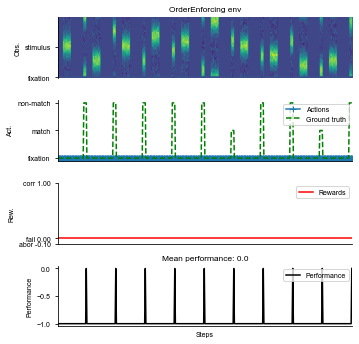

In [3]:
# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=10, def_act=0)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n              # what in batch size and sequence length

# check task
inputs, target = dataset()
mask = target > 0
print(inputs.shape)   # (N_time, batch_size, N_neuron)
print(target.shape)   # (N_time, batch_size)

(48, 2500)

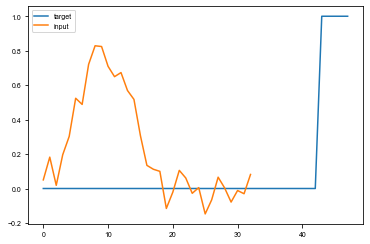

In [4]:
plt.Figure()
plt.plot(target[:, 20])
plt.plot(inputs[15,1,:])
plt.legend(['target', 'input'])
inputs.shape
target.shape

## Define a vanilla continuous-time recurrent network

Here we will define a continuous-time neural network but discretize it in time using the Euler method.
\begin{align}
    \tau \frac{d\mathbf{r}}{dt} = -\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r).
\end{align}

This continuous-time system can then be discretized using the Euler method with a time step of $\Delta t$, 
\begin{align}
    \mathbf{r}(t+\Delta t) = \mathbf{r}(t) + \Delta \mathbf{r} = \mathbf{r}(t) + \frac{\Delta t}{\tau}[-\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)].
\end{align}

In [8]:
def random_weight_intializer(mean, std, rows,cols = 1):

    # Create a random weight matrix
    weight_matrix = np.zeros((rows, cols))

#     weight_matrix = np.zeros((rows, cols),dtype = np.float64)

        
    # Calculate the number of non-zero elements required (approximately 10%)
    num_non_zero = int(0.1 * rows * cols)
    # Get random indices for non-zero elements
    non_zero_indices = np.random.choice(rows * cols, num_non_zero, replace=False)

    # Set the selected indices to non-zero values
    weight_matrix_flat = weight_matrix.flatten()
    weight_matrix_flat[non_zero_indices] = np.random.normal(mean,std,size = len(non_zero_indices))
    # Reshape the matrix back to its original shape
    weight_matrix = torch.tensor(weight_matrix_flat.reshape(rows, cols))
    percentage_of_non_zero_weights = torch.count_nonzero(weight_matrix)/weight_matrix.numel() * 100
    weight_matrix = weight_matrix.type(torch.float32)
    return weight_matrix

In [9]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
    

class CTRNN(nn.Module):
    """Continuous-time RNN.

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size), network input
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, input_size, hidden_size, sigma_rec = 0, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        self.sigma_rec = np.sqrt(alpha) * sigma_rec 
        self.input2h = nn.Linear(input_size, hidden_size)
        self.input2h.weight = nn.Parameter(random_weight_intializer(0,0.28,self.input2h.weight.shape[0],self.input2h.weight.shape[1]))
        self.input2h.bias =   nn.Parameter(random_weight_intializer(0,0.28,self.input2h.bias.shape[0]).reshape(self.input2h.bias.shape[0]))
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2h.weight =   nn.Parameter(random_weight_intializer(0,0.28, self.h2h.weight.shape[0],self.h2h.weight.shape[1]))                                       
        self.h2h.bias =  nn.Parameter(random_weight_intializer(0,0.28, self.h2h.bias.shape[0]).reshape(self.h2h.bias.shape[0]))       

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)
    
    
    def recurrence(self, input, hidden):
        """Recurrence helper."""
        
# recurrent input with noise 
        pre_activation = self.input2h(input) + self.h2h(hidden) 
    
        h_new = torch.relu(hidden * self.oneminusalpha +
                           pre_activation * self.alpha + self.sigma_rec *
                           torch.randn_like(pre_activation))
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size,sigma_rec, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, sigma_rec,**kwargs)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        out = self.fc(rnn_activity)
        return out, rnn_activity

## Train the recurrent network on the decision-making task

In [10]:
import torch.optim as optim

# Instantiate the network and print information
hidden_size = 150
net = RNNNet(input_size=input_size, hidden_size=hidden_size,sigma_rec=0,
             output_size=output_size, dt=env.dt)
print(net)

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=33, out_features=150, bias=True)
    (h2h): Linear(in_features=150, out_features=150, bias=True)
  )
  (fc): Linear(in_features=150, out_features=3, bias=True)
)


In [16]:
# Use Adam optimizer
optimizer = optim.Adam(net.rnn.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()


first_training_phase = True
second_training_phase = False
third_training_phase = False
fourth_training_phase = True

noise_increase = 0.05
accuracy_criterion = 0.99
running_loss = 0
running_acc = 0
small_synapse_percentage = 0.05
env.stim_range = 0
num_of_steps_trials = int((2160 - 200)/5)
dataset.batch_size = 200
env.sigma_rec = 0
stim_range_limit = 5
# env.sigma = 0.6

for i in range(2000):
    inputs, labels_np = dataset()
    labels_np = labels_np.flatten()
    inputs = torch.from_numpy(inputs).type(torch.float32)
    labels = torch.from_numpy(labels_np).type(torch.long)

    y_onehot = torch.FloatTensor(labels.size(0), output_size)
    y_onehot[:,:]=0
    
    labelnum = np.arange(output_size)
    
    for  ilabel, y in enumerate(labelnum):
        batch_idx = labels_np==y
        y_onehot[batch_idx,y]=1
    
    
    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output, _ = net(inputs)
    output = output.view(-1, output_size)
#     loss = criterion(output, labels)
 
    loss = criterion(output,y_onehot)
    
    loss.backward()
    optimizer.step()    # Does the update
    
    
    running_loss += loss.item()
    # Compute performance
    output_np = np.argmax(output.detach().numpy(), axis=-1)
    ind = labels_np > 0  # Only analyze time points when target is not fixation
    
    running_acc_curr = np.mean(labels_np[ind] == output_np[ind])
    running_acc += running_acc_curr
    
    
    
    # First Training phase
    if first_training_phase == True and running_acc_curr >= 0.99:
        env.sigma = 0.0
        if running_acc_curr >= accuracy_criterion:
            first_training_phase = False
            second_training_phase = True
            accuracy_criterion = 0.87
            print('End of First training phase')
    # Second Training phase
    elif second_training_phase == True and running_acc_curr >= accuracy_criterion:
        env.sigma = 0.6
        if net.rnn.sigma_rec >= np.sqrt(net.rnn.alpha) * 0.6:
            net.rnn.sigma_rec = np.sqrt(net.rnn.alpha) * 0.6
            third_training_phase = True
            second_training_phase = False
            print('End of second training phase')
        else:
            net.rnn.sigma_rec += np.sqrt(net.rnn.alpha) * noise_increase
    # Third Training phase
    elif third_training_phase == True and running_acc_curr >= accuracy_criterion:
        rnn_weights = net.rnn.h2h.weight
        zero_weights_index = abs(rnn_weights) < np.quantile(abs(rnn_weights.detach().numpy()),small_synapse_percentage)
        with torch.no_grad(): 
            net.rnn.h2h.weight[zero_weights_index] = 0
        if small_synapse_percentage <= 0.88:
            small_synapse_percentage += 0.02
        print('Small Synapse Percent', small_synapse_percentage)
    # Fourth Training phase
        if torch.count_nonzero(net.rnn.h2h.weight)/net.rnn.h2h.weight.numel() <= 0.12 and small_synapse_percentage >= 0.88:
            if fourth_training_phase == True:
                print('End of third training phase')
                if env.stim_range != stim_range_limit:
                    env.stim_range += 1
                else:
                    if dataset.batch_size != 2160:
                        dataset.batch_size += num_of_steps_trials
                    elif dataset.batch_size == 2160 and running_acc_curr >= 0.87 and env.stim_range == stim_range_limit:
                        break 
                    else:
                        dataset.batch_size = 2160
            
    print('Step {}, Loss {:0.4f}, Acc {:0.3f},Current_Acc {:0.3f}, Trials {}, Stim_range {}, Sigma_rec {:0.3f}'.format(i+1, running_loss, running_acc, running_acc_curr, dataset.batch_size, env.stim_range, net.rnn.sigma_rec))
    running_loss = 0
    running_acc = 0        

In [17]:
# Save the model
torch.save(net,'Model_RNN_8')

In [11]:
# Set the tme period and parameters for the prediction 

timing   = {'fixation': 500,
                'sample': 650,
                'first_delay': 1000,
#                 'first_delay':200,
                'test': 250 }
kwargs = {'timing': timing, 'sigma': 0.6, 'stim_range': 5, 'dim_ring': 32,'dt':50}
env = gym.make(task, **kwargs)
env.reset(no_step=True)
env.timing

{'fixation': 500, 'sample': 650, 'first_delay': 1000, 'test': 250}

### Caculating average accuracy over 400 trials for each angle

In [15]:
# Load the model
net = torch.load('Model_RNN_2')
perf = 0
model_num = 2
num_trial = 100 
activity_dict = {}
trial_infos = {}
output_dict = {}
average_acc = np.zeros(shape = (12,12))

     
for j in range(env.stim_range+1):
    for m in range(env.stim_range+1):
        for k in [0,1]:
            for l in ['match', 'non-match']:
                accu_arr = []
                for i in range(num_trial):
#                     create new trials with a specific sample
                    trial_spec = {'sample_index':j/6,'test_index':m/6,'sample_category':k,'ground_truth':l}
                    env.new_trial(**trial_spec)
                    ob, gt = env.ob, env.gt
                    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
                    action_pred, rnn_activity = net(inputs)
                    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
                    output = action_pred
                    action_pred = action_pred[:, 0, :].detach().numpy()
                    output_dict[i] = action_pred[int(env.start_ind['sample'] - 100/env.dt):env.end_ind['sample']]
                    labels_np = gt
                    labels_np = labels_np.flatten()
                    output_np = np.argmax(output.detach().numpy(), axis=-1)
                    ind = labels_np > 0  # Only analyze time points when target is not fixation
                    running_acc_curr = np.mean(labels_np[ind] == output_np[ind])
                    accu_arr.append(running_acc_curr)
                    trial_infos[i] = env.trial.copy()
                if l == 'match':
                    average_acc[j + k * 6, m+k*6] = np.mean(accu_arr)
                else:
                    average_acc[j + k * 6, m + (1-k)*6] = np.mean(accu_arr)


0.8547916666666667


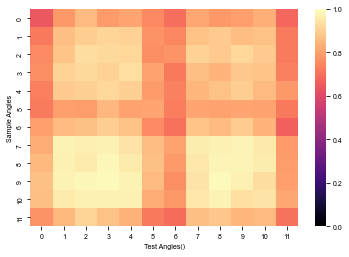

In [16]:
# plt.imshow(average_acc)
avg_1 = np.mean(average_acc.flatten())
import seaborn 

print(avg_1)

hm = sns.heatmap(data = average_acc, cmap = 'magma',vmin=0,vmax=1)
plt.xlabel('Test Angles()')
plt.ylabel('Sample Angles')

fig = hm.get_figure()
 

# displaying the plotted heatmap
plt.show()
for i in range(1,11):
    if i == model_num:
        fig.savefig('Model_{}_activity_accuracy'.format(i))

### Getting the recurrent neural activities 

In [29]:
net = torch.load('Model_RNN_10')
model_num = 10
perf = 0
num_trial = 400 
activity_dict = {}
activity_dict_sample = {}
activity_dict_test = {}

activity_dict_1 = {}
activity_dict_delay = {}
activity_dict_all_trail = {}

trial_infos = {}
output_dict = {}
# net.rnn.sigma_rec = 0.6

for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    action_pred = action_pred[:, 0, :].detach().numpy()
    # sample
    activity_dict_sample[i] = rnn_activity[int(env.start_ind['sample'] - 100/env.dt):env.end_ind['sample']]
    #first delay
    activity_dict_delay[i] = rnn_activity[int(env.start_ind['sample'] + 800/env.dt):int(env.start_ind['sample']+1550/env.dt)]
    #first delay
    activity_dict_all_trail[i] = rnn_activity[int(env.start_ind['sample'] - 250/env.dt):int(env.start_ind['sample']+1900/env.dt)]
    # test
    activity_dict_test[i] = rnn_activity[int(env.start_ind['sample'] + 1600/env.dt):int(env.start_ind['sample'] + 2650/env.dt)]
    output_dict[i] = action_pred[env.start_ind['sample']:env.end_ind['sample']]
    trial_infos[i] = env.trial.copy()

In [30]:
# trial_infos
df = pd.DataFrame()
for i in range(len(trial_infos)):
    df = df.append(trial_infos[i], ignore_index=True)

# Rounding the sample theta and test theta for 5 decimal points    
df['sample_theta'] = np.round(df['sample_theta'],5)
df['test_theta'] = np.round(df['test_theta'],5)

## Plotting the Activities for the recurrent neurons

### Ploting for sample period

In [31]:
# Concatenate activity for PCA

unique_angle_0 = np.sort(df['sample_theta'].loc[df['sample_category'] == 0].unique())
unique_angle_1 = np.sort(df['sample_theta'].loc[df['sample_category'] == 1].unique())
unique_angle = np.sort(df['sample_theta'].unique())

activity_theta_dict_0 = {}
activity_theta_dict_1 = {}

for i in unique_angle:
    if i in unique_angle_0:
        trials_0 = df[df['sample_theta'] == i].index
        activity_theta_0 = np.mean(np.array([activity_dict_sample[i] for i in trials_0]), axis=0)
        activity_theta_dict_0[i] = activity_theta_0
    else:
        trials_1 = df[df['sample_theta'] == i].index
        activity_theta_1 = np.mean(np.array([activity_dict_sample[i] for i in trials_1]), axis=0)
        activity_theta_dict_1[i] = activity_theta_1
        
        
activity_0 = np.stack(list([activity_theta_dict_0[i] for i in unique_angle_0]), axis=2)
activity_1 = np.stack(list([activity_theta_dict_1[i] for i in unique_angle_1]), axis=2)


activity = np.dstack([activity_0,activity_1])
print(activity.shape)
activity = activity.transpose(1,0,2)
print('Shape of the neural activity: (Neurons, Time Points, Stimulus): ', activity.shape)

(15, 150, 12)
Shape of the neural activity: (Neurons, Time Points, Stimulus):  (150, 15, 12)


In [32]:
from dPCA import dPCA
from sklearn.manifold import MDS
dpca = dPCA.dPCA(labels='tA',n_components = 3,regularizer=None)


# Computing PCA and retaining components that explains 95% of the variance for removing the noise 
pca_sample = PCA(n_components=0.95)
act_pc = pca_sample.fit_transform(activity.reshape(150,activity.shape[1]*activity.shape[2]).T).T
act_pc = act_pc.reshape(act_pc.shape[0],activity.shape[1],activity.shape[2])

# DPCA for plotting the activities
Z = dpca.fit_transform(act_pc)

# Seperating the dpca components
Z_a = Z['A']
Z_t = Z['t']
Z_ta = Z['tA']


# Concatenating the componets that explains the variance due to the stimulus(Z_a) 
# and variance due to combine effect of stimulus and time (Z_ta)
con_z = np.concatenate([Z_a,Z_ta],axis = 0)

print(con_z.shape)
con_z = con_z.transpose(0,2,1)
con_z = con_z.reshape(6,activity.shape[2]*activity.shape[1])
con_z.shape

(6, 15, 12)


{'t': [0.3156143, 0.045479957, 8.477913e-05],
 'A': [0.37271625, 0.00029094054, 2.1036449e-05],
 'tA': [0.07758158, 0.005654698, 9.806886e-05]}

(3, 180)
(3, 15, 12)


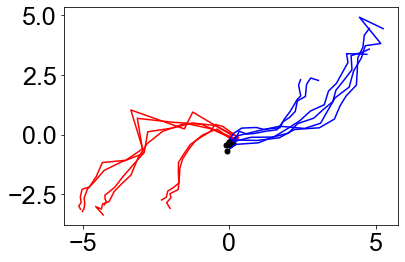

In [33]:
# Plotting using Multidimentional scaling 
embedding = MDS(n_components=3)
X_transformed = embedding.fit_transform(con_z.T.astype(np.float64))
X_transformed = X_transformed.transpose(1,0)
print(X_transformed.shape)


X_transformed = X_transformed.reshape(3,activity.shape[2],activity.shape[1])
X_transformed = X_transformed.transpose(0,2,1)
print(X_transformed.shape)


for i in range(12):
    if i <=5 :
        plt.plot(X_transformed[0,:,i],X_transformed[1,:,i],color='red')
        plt.plot(X_transformed[0, 0, i], X_transformed[1,0,i], 'o-', alpha=1, marker='o', color='black', ms=5)
    else:
        plt.plot(X_transformed[0,:,i],X_transformed[1,:,i], color='blue')
        plt.plot(X_transformed[0, 0, i], X_transformed[1,0,i], 'o-', alpha=1, marker='o', color='black', ms=5)


In [34]:
# PCA for plotting the activities with 3 components
pca = PCA(n_components=3)
X_transformed = pca.fit_transform(con_z.T).T
print(X_transformed.shape)

X_transformed = X_transformed.reshape(3,activity.shape[2],activity.shape[1])
X_transformed = X_transformed.transpose(0,2,1)
print(X_transformed.shape)

(3, 180)
(3, 15, 12)


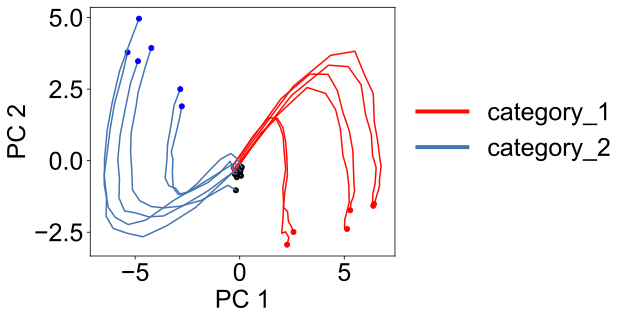

In [35]:
# Plotting the activities
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

shade_alpha      = 0.2
lines_alpha      = 0.8

# Set your custom color palette
colors = ["#FF0B04", "#4374B3"]
pal = sns.color_palette(colors, 2)
%config InlineBackend.figure_format = 'svg'
    
    
def add_orientation_legend(ax):
    custom_lines = [Line2D([0], [0], color=pal[0], lw=4) if k == 1 else Line2D([0], [0], color=pal[1], lw=4) for
                    k in range(1,3)]
    labels = ['category_{}'.format(i) for i in range(1,3)]
    ax.legend(custom_lines, labels,
              frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0,0,0.9,1])
    
    
    
f, axes = plt.subplots(1, 1, figsize=[10, 5], sharey=True, sharex=True)
for i in range(12):
    plt.plot(X_transformed[0, 0, i], X_transformed[1,0,i], 'o-', alpha=1, marker='o', color= 'black', ms=5)
    if i <= 5 :
        axes.plot(X_transformed[0,:,i],X_transformed[1,:,i],color = pal[0])
        axes.plot(X_transformed[0, X_transformed.shape[1]-1, i], X_transformed[1,X_transformed.shape[1]-1,i], 'o-', alpha=1, marker='o', color='red', ms=5)
    else:
        axes.plot(X_transformed[0,:,i],X_transformed[1,:,i], color = pal[1])
        axes.plot(X_transformed[0, X_transformed.shape[1]-1, i], X_transformed[1,X_transformed.shape[1]-1,i], 'o-', alpha=1, marker='o', color='blue', ms=5)
axes.set_ylabel('PC {}'.format(2))
axes.set_xlabel('PC {}'.format(1))
add_orientation_legend(axes)

# Saving the figure according to the model number and figure type
for i in range(1,11):
    if i == model_num:
        plt.savefig('Model_{}_activity_sample'.format(i))

### Plotting for delay period

In [36]:
# Concatenate activity for PCA

def activity_unique_angle(activity_dict):
    unique_angle_0 = np.sort(df['sample_theta'].loc[(df['sample_category'] == 0)].unique())
    unique_angle_1 = np.sort(df['sample_theta'].loc[df['sample_category'] == 1].unique())
    unique_angle = np.sort(df['sample_theta'].unique())

    activity_theta_dict_0 = {}
    activity_theta_dict_1 = {}

    for i in unique_angle:
        if i in unique_angle_0:
            trials_0 = df[df['sample_theta'] == i].index
            activity_theta_0 = np.mean(np.array([activity_dict[i] for i in trials_0]), axis=0)
            activity_theta_dict_0[i] = activity_theta_0
        else:
            trials_1 = df[df['sample_theta'] == i].index
            activity_theta_1 = np.mean(np.array([activity_dict[i] for i in trials_1]), axis=0)
            activity_theta_dict_1[i] = activity_theta_1


    activity_0 = np.stack(list([activity_theta_dict_0[i] for i in unique_angle_0]), axis=2)
    activity_1 = np.stack(list([activity_theta_dict_1[i] for i in unique_angle_1]), axis=2)


    activity = np.dstack([activity_0,activity_1])
    print(activity.shape)
    activity = activity.transpose(1,0,2)
    print('Shape of the neural activity: (Neurons, Time Points, Stimulus): ', activity.shape)
    return activity

activity_delay = activity_unique_angle(activity_dict_delay)
activity_all_trail = activity_unique_angle(activity_dict_all_trail)

(15, 150, 12)
Shape of the neural activity: (Neurons, Time Points, Stimulus):  (150, 15, 12)
(43, 150, 12)
Shape of the neural activity: (Neurons, Time Points, Stimulus):  (150, 43, 12)


In [37]:
from dPCA import dPCA
from sklearn.manifold import MDS
dpca = dPCA.dPCA(labels='tA',n_components = 3,regularizer=None)


# Computing PCA and retaining components that explains 95% of the variance for removing the noise 
pca_2 = PCA(n_components=0.95)
pca_2.fit(activity_delay.reshape(150,activity_delay.shape[1]*activity_delay.shape[2]).T)

# Applying transform to the delay period
act_pc_delay = pca_2.transform(activity_delay.reshape(150,activity_delay.shape[1]*activity_delay.shape[2]).T).T

# Applying transform to the whole trial period
act_pc_all_trial = pca_2.transform(activity_all_trail.reshape(150,activity_all_trail.shape[1]*activity_all_trail.shape[2]).T).T

print(act_pc_delay.shape)
print(act_pc_all_trial.shape)
print(pca_2.explained_variance_ratio_)

(4, 180)
(4, 516)
[0.53441054 0.2765204  0.13185829 0.01965132]


In [38]:
act_pc_delay = act_pc_delay.reshape(act_pc_delay.shape[0],activity_delay.shape[1],activity_delay.shape[2])
act_pc_all_trial = act_pc_all_trial.reshape(act_pc_all_trial.shape[0],activity_all_trail.shape[1],activity_all_trail.shape[2])

# DPCA
dpca.fit(act_pc_delay)
Z = dpca.transform(act_pc_all_trial)


# Seperating the dpca components
Z_a = Z['A']
Z_t = Z['t']
Z_ta = Z['tA']
print(Z_ta.shape)

dpca.explained_variance_ratio_

(3, 43, 12)


{'t': [0.34040514, 0.000103404294, 3.8719254e-06],
 'A': [0.50184256, 3.390348e-05, 5.27201e-06],
 'tA': [0.11679601, 0.10203384, 1.2248139e-05]}

In [17]:
# Setting the timevector
time_vect = np.arange(-250,1900,50)       

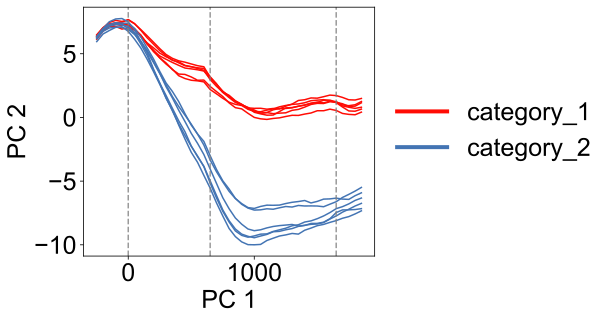

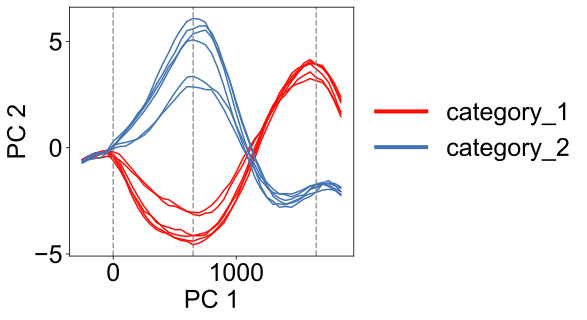

In [40]:
# Plotting the DPCA components

import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

shade_alpha      = 0.2
lines_alpha      = 0.8

# Set your custom color palette
colors = ["#FF0B04", "#4374B3"]
pal = sns.color_palette(colors, 2)
%config InlineBackend.figure_format = 'svg'
    
    
start_stim = env.start_ind['fixation']
start_stim_sample = env.start_ind['sample']*50+150
start_stim_test = env.start_ind['first_delay'] * 50 +500
def add_stim_to_plot(ax):
#     ax.axvspan(start_stim, end_stim, alpha=shade_alpha,
#                color='gray')
    ax.axvline(start_stim, alpha=lines_alpha, color='gray', ls='--')
    ax.axvline(start_stim_sample, alpha=lines_alpha, color='gray', ls='--')
    ax.axvline(start_stim_test, alpha=lines_alpha, color='gray', ls='--')
    
    
def add_orientation_legend(ax):
    unique_angle = np.sort(df['sample_theta'].unique())
    custom_lines = [Line2D([0], [0], color=pal[0], lw=4) if k ==1 else Line2D([0], [0], color=pal[1], lw=4) for
                    k in range(1,3)]
    labels = ['category_{}'.format(i) for i in range(1,3)]
    ax.legend(custom_lines, labels,
              frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout(rect=[0,0,0.9,1])
    
    
for i in [0,1]:
    if i == 0:
        f, axes = plt.subplots(1, 1, figsize=[10, 5], sharey=True, sharex=True)
        Z_plot = Z_a
        plot_type = 'a'
        for i in range(12):
            if i <= 5 :
                axes.plot(time_vect,Z_plot[0,:,i],color = pal[0])
            else:
                axes.plot(time_vect,Z_plot[0,:,i], color = pal[1])
        axes.set_ylabel('PC {}'.format(2))
        axes.set_xlabel('PC {}'.format(1))
        add_stim_to_plot(axes)
        add_orientation_legend(axes)
        for i in range(1,11):
            if i == model_num:
                plt.savefig('Model_{}_activity_delay_{}'.format(i,plot_type))
    else:
        f, axes = plt.subplots(1, 1, figsize=[10, 5], sharey=True, sharex=True)
        Z_plot = Z_ta
        plot_type = 'ta'
        for i in range(12):
            if i <= 5 :
                axes.plot(time_vect,Z_plot[0,:,i],color = pal[0])
            else:
                axes.plot(time_vect,Z_plot[0,:,i], color = pal[1])
        axes.set_ylabel('PC {}'.format(2))
        axes.set_xlabel('PC {}'.format(1))
        add_stim_to_plot(axes)
        add_orientation_legend(axes)
        for i in range(1,11):
            if i == model_num:
                plt.savefig('Model_{}_activity_delay_{}'.format(i,plot_type))

### Plot For test 

In [41]:
# Concatenate activity for PCA

unique_angle_test = np.sort(df['test_theta'].unique())
unique_angle_0 = []
unique_angle_1 = []
unique_angle_2 = []
unique_angle_3 = []


activity_theta_dict_0 = {}
activity_theta_dict_1 = {}
activity_theta_dict_2 = {}
activity_theta_dict_3 = {}

for i in unique_angle_test:
    angle_cat_0 = df[(df['ground_truth']=='match') & (df['sample_category'] == 0) & (df['test_theta'] == i)].index    
    if len(angle_cat_0) != 0:
        activity_theta_0 = np.mean(np.array([activity_dict_test[i] for i in angle_cat_0]), axis=0)
        activity_theta_dict_0[i] = activity_theta_0
        unique_angle_0.append(i)
    angle_cat_1 = df[(df['ground_truth']=='match') & (df['sample_category'] == 1) & (df['test_theta'] == i)].index    
    if len(angle_cat_1) != 0:
        activity_theta_1 = np.mean(np.array([activity_dict_test[i] for i in angle_cat_1]), axis=0)
        activity_theta_dict_1[i] = activity_theta_1
        unique_angle_1.append(i)

    angle_cat_2 = df[(df['ground_truth']=='non-match') & (df['sample_category'] == 0) & (df['test_theta'] == i)].index    
    if len(angle_cat_2) != 0:
        activity_theta_2 = np.mean(np.array([activity_dict_test[i] for i in angle_cat_2]), axis=0)
        activity_theta_dict_2[i] = activity_theta_2
        unique_angle_2.append(i)

    angle_cat_3 = df[(df['ground_truth']=='non-match') & (df['sample_category'] == 1) & (df['test_theta'] == i)].index    
    if len(angle_cat_3) != 0:
        activity_theta_3 = np.mean(np.array([activity_dict_test[i] for i in angle_cat_3]), axis=0)
        activity_theta_dict_3[i] = activity_theta_3
        unique_angle_3.append(i)

activity0 = np.stack(list([activity_theta_dict_0[i] for i in unique_angle_0]), axis=2)
activity1 = np.stack(list([activity_theta_dict_1[i] for i in unique_angle_1]), axis=2)
activity2 = np.stack(list([activity_theta_dict_2[i] for i in unique_angle_2]), axis=2)
activity3 = np.stack(list([activity_theta_dict_3[i] for i in unique_angle_3]), axis=2)


activity = np.dstack([activity0, activity1, activity2, activity3])
print(activity.shape)
activity = activity.transpose(1,0,2)
print('Shape of the neural activity: (Neurons, Time Points, Stimulus): ', activity.shape)

(6, 150, 24)
Shape of the neural activity: (Neurons, Time Points, Stimulus):  (150, 6, 24)


In [44]:
from dPCA import dPCA
from sklearn.manifold import MDS

dpca = dPCA.dPCA(labels='tA',n_components = 3,regularizer=None)

# Computing PCA and retaining components that explains 95% of the variance for removing the noise 

pca_test = PCA(n_components=0.95)
act_pc = pca_test.fit_transform(activity.reshape(150,activity.shape[1]*activity.shape[2]).T).T
act_pc.shape
pca_test.explained_variance_ratio_

array([0.5190666 , 0.17203271, 0.12662135, 0.08300947, 0.02787946,
       0.01507787, 0.00920183], dtype=float32)

In [46]:
act_pc = act_pc.reshape(act_pc.shape[0],activity.shape[1],activity.shape[2])

# DPCA
Z = dpca.fit_transform(act_pc)

# Seperating the dpca components
Z_a = Z['A']
Z_t = Z['t']
Z_ta = Z['tA']
Z_a.shape
dpca.explained_variance_ratio_

# Concatenating the componets that explains the variance due to the stimulus(Z_a) 
# and variance due to combine effect of stimulus and time (Z_ta)
con_z = np.concatenate([Z_a,Z_ta],axis = 0)

In [47]:
print(con_z.shape)
con_z = con_z.transpose(0,2,1)
con_z = con_z.reshape(6,activity.shape[2]*activity.shape[1])
con_z.shape

(6, 6, 24)


(6, 144)

In [48]:
# PLot using MUltidimensional scaling

# embedding = MDS(n_components=3)
# X_transformed = embedding.fit_transform(con_z.T.astype(np.float64))
# X_transformed = X_transformed.transpose(1,0)
# print(X_transformed.shape)


# X_transformed = X_transformed.reshape(3,activity.shape[2],activity.shape[1])
# X_transformed = X_transformed.transpose(0,2,1)
# print(X_transformed.shape)

# f, axes = plt.subplots(1, 1, figsize=[10, 5], sharey=True, sharex=True)
# for i in range(24):
#     plt.plot(X_transformed[0, 0, i], X_transformed[1,0,i], 'o-', alpha=1, marker='o', color= 'black', ms=5)
#     if i <= 5 :
#         axes.plot(X_transformed[0,:,i],X_transformed[1,:,i],color = pal[0])
#     elif i <= 11:
#         axes.plot(X_transformed[0,:,i],X_transformed[1,:,i], color = pal[1])
#     elif i <= 17 :
#         axes.plot(X_transformed[0,:,i],X_transformed[1,:,i],color = pal[2])
#     else:
#         axes.plot(X_transformed[0,:,i],X_transformed[1,:,i], color = pal[3])
# axes.set_ylabel('PC {}'.format(2))
# axes.set_xlabel('PC {}'.format(1))


In [49]:
# PCA for plotting the activities with 3 components

pca = PCA(n_components=3)
X_transformed = pca.fit_transform(con_z.T).T
print(X_transformed.shape)


X_transformed = X_transformed.reshape(3,activity.shape[2],activity.shape[1])
X_transformed = X_transformed.transpose(0,2,1)
print(X_transformed.shape)

(3, 144)
(3, 6, 24)


## Plot using SNS

### Plot for Test

4


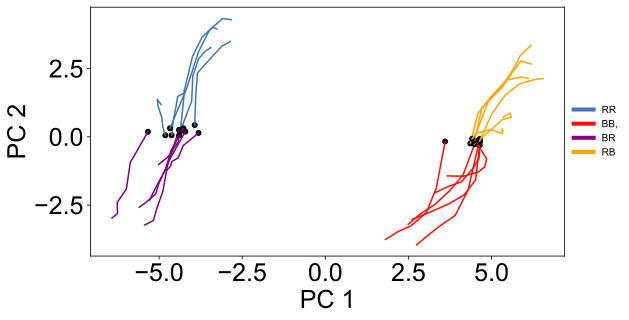

In [50]:
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

shade_alpha      = 0.2
lines_alpha      = 0.8

# Set your custom color palette
colors = ["#4374B3","#FF0B04",'#800080','#FFA500']
pal = sns.color_palette(colors, 4)
%config InlineBackend.figure_format = 'svg'
    
def add_stim_to_plot(ax):
    ax.axvspan(start_stim, end_stim, alpha=shade_alpha,
               color='gray')
    ax.axvline(start_stim, alpha=lines_alpha, color='gray', ls='--')
    ax.axvline(end_stim, alpha=lines_alpha, color='gray', ls='--')
    
def add_orientation_legend(ax):
    custom_lines = []
    for k in range(4):
        if k == 0:
            custom_lines.append(Line2D([0], [0], color=pal[0], lw=4))
        elif k == 1:
            custom_lines.append(Line2D([0], [0], color=pal[1], lw=4))
        elif k == 2:
            custom_lines.append(Line2D([0], [0], color=pal[2], lw=4))
        else:
            custom_lines.append(Line2D([0], [0], color=pal[3], lw=4))
    print(len(custom_lines))
    lables_list = ['RR','BB,','BR','RB']        
    labels = [i for i in lables_list]
    ax.legend(custom_lines, labels,
              frameon=False, loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 10})
    plt.tight_layout(rect=[0,0,0.9,1])
    
    
f, axes = plt.subplots(1, 1, figsize=[10, 5], sharey=True, sharex=True)
for i in range(24):
    plt.plot(X_transformed[0, 0, i], X_transformed[1,0,i], 'o-', alpha=1, marker='o', color= 'black', ms=5)
    if i <= 5 :
        axes.plot(X_transformed[0,:,i],X_transformed[1,:,i],color = pal[0])
    elif i <= 11:
        axes.plot(X_transformed[0,:,i],X_transformed[1,:,i], color = pal[1])
    elif i <= 17 :
        axes.plot(X_transformed[0,:,i],X_transformed[1,:,i],color = pal[2])
    else:
        axes.plot(X_transformed[0,:,i],X_transformed[1,:,i], color = pal[3])
axes.set_ylabel('PC {}'.format(2))
axes.set_xlabel('PC {}'.format(1))
# sns.despine(right=True, top=True)
add_orientation_legend(axes)
for i in range(1,11):
    if i == model_num:
        plt.savefig('Model_{}_activity_test'.format(i))